In [ ]:
#| hide
!pip install -Uqq nixtla

In [ ]:
#| hide 
from nixtla.utils import in_colab

In [ ]:
#| hide 
IN_COLAB = in_colab()

In [ ]:
#| hide
if not IN_COLAB:
    from nixtla.utils import colab_badge
    from dotenv import load_dotenv

# Exogenous variables

Exogenous variables or external factors are crucial in time series forecasting as they provide additional information that might influence the prediction. These variables could include holiday markers, marketing spending, weather data, or any other external data that correlate with the time series data you are forecasting.

For example, if you're forecasting ice cream sales, temperature data could serve as a useful exogenous variable. On hotter days, ice cream sales may increase.

To incorporate exogenous variables in TimeGPT, you'll need to pair each point in your time series data with the corresponding external data.

In [ ]:
#| echo: false
if not IN_COLAB:
    load_dotenv()
    colab_badge('docs/tutorials/01_exogenous_variables')

[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Nixtla/nixtla/blob/main/nbs/docs/tutorials/01_exogenous_variables.ipynb)

## 1. Import packages
First, we import the required packages and initialize the Nixtla client.

In [ ]:
import pandas as pd
from nixtla import NixtlaClient

In [ ]:
nixtla_client = NixtlaClient(
    # defaults to os.environ.get("NIXTLA_API_KEY")
    api_key = 'my_api_key_provided_by_nixtla'
)

> 👍 Use an Azure AI endpoint
> 
> To use an Azure AI endpoint, remember to set also the `base_url` argument:
> 
> `nixtla_client = NixtlaClient(base_url="you azure ai endpoint", api_key="your api_key")`

In [ ]:
#| hide
if not IN_COLAB:
    nixtla_client = NixtlaClient()

## 2. Load data

Let's see an example on predicting day-ahead electricity prices. The following dataset contains the hourly electricity price (`y` column) for five markets in Europe and US, identified by the `unique_id` column. The columns from `Exogenous1` to `day_6` are exogenous variables that TimeGPT will use to predict the prices.

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/electricity-short-with-ex-vars.csv')
df.head()

,unique_id,ds,y,Exogenous1,Exogenous2,day_0,day_1,day_2,day_3,day_4,day_5,day_6
0,BE,2011-01-09 00:00:00,32.54,63000.0,63065.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,BE,2011-01-09 01:00:00,21.55,58800.0,62715.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,BE,2011-01-09 02:00:00,15.71,58500.0,61952.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,BE,2011-01-09 03:00:00,10.58,54300.0,59262.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,BE,2011-01-09 04:00:00,10.32,51900.0,56883.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## 3a. Forecasting electricity prices using future exogenous variables

To produce forecasts with future exogenous variables we have to add the future values of the exogenous variables. Let's read this dataset. In this case, we want to predict 24 steps ahead, therefore each `unique_id` will have 24 observations.

In [ ]:
future_ex_vars_df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/electricity-short-future-ex-vars.csv')
future_ex_vars_df.head()

,unique_id,ds,Exogenous1,Exogenous2,day_0,day_1,day_2,day_3,day_4,day_5,day_6
0,BE,2016-12-31 00:00:00,70318.0,64108.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,BE,2016-12-31 01:00:00,67898.0,62492.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,BE,2016-12-31 02:00:00,68379.0,61571.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,BE,2016-12-31 03:00:00,64972.0,60381.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,BE,2016-12-31 04:00:00,62900.0,60298.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Let's call the `forecast` method, adding this information:

In [ ]:
timegpt_fcst_ex_vars_df = nixtla_client.forecast(df=df, X_df=future_ex_vars_df, h=24, level=[80, 90])
timegpt_fcst_ex_vars_df.head()

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: h
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Querying model metadata...
INFO:nixtla.nixtla_client:Using future exogenous features: ['Exogenous1', 'Exogenous2', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


,unique_id,ds,TimeGPT,TimeGPT-hi-80,TimeGPT-hi-90,TimeGPT-lo-80,TimeGPT-lo-90
0,BE,2016-12-31 00:00:00,46.036026,54.296190,57.903230,37.775864,34.168823
1,BE,2016-12-31 01:00:00,39.669830,47.451150,51.088530,31.888512,28.251130
2,BE,2016-12-31 02:00:00,42.782482,50.666080,53.985588,34.898884,31.579376
3,BE,2016-12-31 03:00:00,33.456486,41.924340,45.633470,24.988634,21.279505
4,BE,2016-12-31 04:00:00,33.013190,42.022102,45.891556,24.004282,20.134827


> 📘 Available models in Azure AI
>
> If you are using an Azure AI endpoint, please be sure to set `model="azureai"`:
>
> `nixtla_client.forecast(..., model="azureai")`
> 
> For the public API, we support two models: `timegpt-1` and `timegpt-1-long-horizon`. 
> 
> By default, `timegpt-1` is used. Please see [this tutorial](https://docs.nixtla.io/docs/tutorials-long_horizon_forecasting) on how and when to use `timegpt-1-long-horizon`.

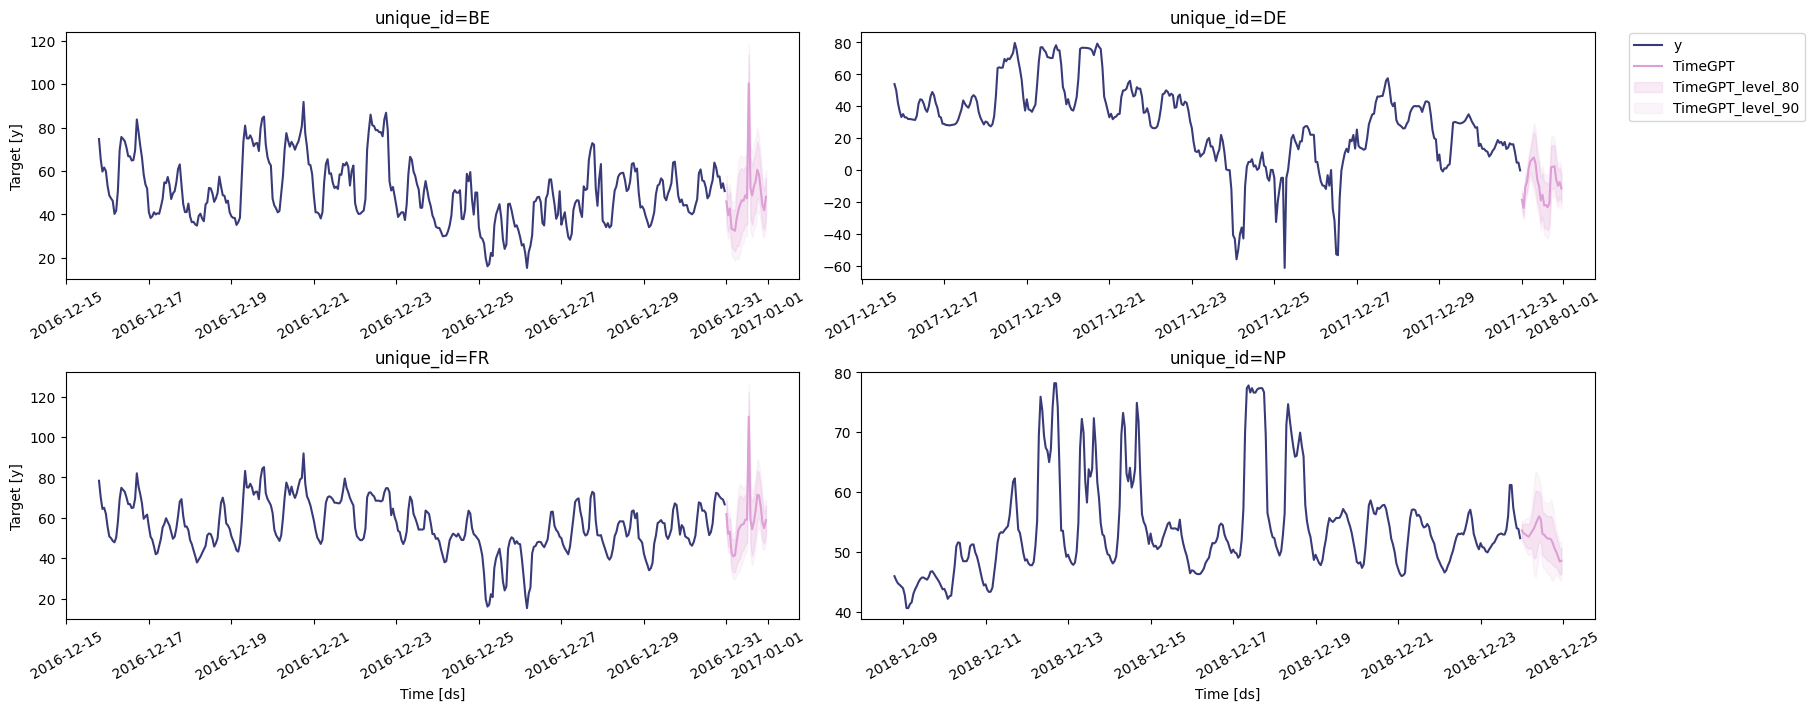

In [ ]:
nixtla_client.plot(
    df[['unique_id', 'ds', 'y']], 
    timegpt_fcst_ex_vars_df, 
    max_insample_length=365, 
    level=[80, 90], 
)

We can also show the importance of the features.

<Axes: ylabel='features'>

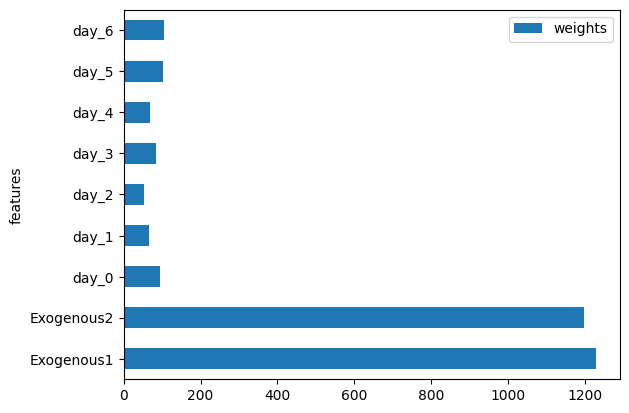

In [ ]:
nixtla_client.weights_x.plot.barh(x='features', y='weights')

This plot shows that `Exogenous1` and `Exogenous2` are the most important for this forecasting task, as they have the largest weight.

## 3b. Forecasting electricity prices using historic exogenous variables

In the example above, we just loaded the future exogenous variables. Often, these are not available because these variables are unknown. We can also make forecasts using only historic exogenous variables. This can be done by adding the `hist_exog_list` argument with the list of columns of `df` to be considered as historical. In that case, we can pass all extra columns available in `df` as historic exogenous variables using `hist_exog_list=['Exogenous1', 'Exogenous2', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6']`.

::: {.callout-important}
If you include historic exogenous variables in your model, you are _implicitly_ making assumptions about the future of these exogenous variables in your forecast. It is recommended to make these assumptions explicit by making use of future exogenous variables.
::: 

Let's call the `forecast` method, adding `hist_exog_list`:

In [ ]:
timegpt_fcst_hist_ex_vars_df = nixtla_client.forecast(
    df=df, 
    h=24, 
    level=[80, 90], 
    hist_exog_list=['Exogenous1', 'Exogenous2', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6'],
)
timegpt_fcst_hist_ex_vars_df.head()

INFO:nixtla.nixtla_client:Validating inputs...


INFO:nixtla.nixtla_client:Inferred freq: h
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using historical exogenous features: ['Exogenous1', 'Exogenous2', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


,unique_id,ds,TimeGPT,TimeGPT-hi-80,TimeGPT-hi-90,TimeGPT-lo-80,TimeGPT-lo-90
0,BE,2016-12-31 00:00:00,48.005688,56.266388,59.872803,39.744987,36.138573
1,BE,2016-12-31 01:00:00,49.051872,56.832905,60.470290,41.270840,37.633453
2,BE,2016-12-31 02:00:00,48.146250,56.030890,59.349403,40.261612,36.943100
3,BE,2016-12-31 03:00:00,47.408264,55.876064,59.585114,38.940464,35.231415
4,BE,2016-12-31 04:00:00,49.625957,58.634792,62.504074,40.617123,36.747840


> 📘 Available models in Azure AI
>
> If you are using an Azure AI endpoint, please be sure to set `model="azureai"`:
>
> `nixtla_client.forecast(..., model="azureai")`
> 
> For the public API, we support two models: `timegpt-1` and `timegpt-1-long-horizon`. 
> 
> By default, `timegpt-1` is used. Please see [this tutorial](https://docs.nixtla.io/docs/tutorials-long_horizon_forecasting) on how and when to use `timegpt-1-long-horizon`.

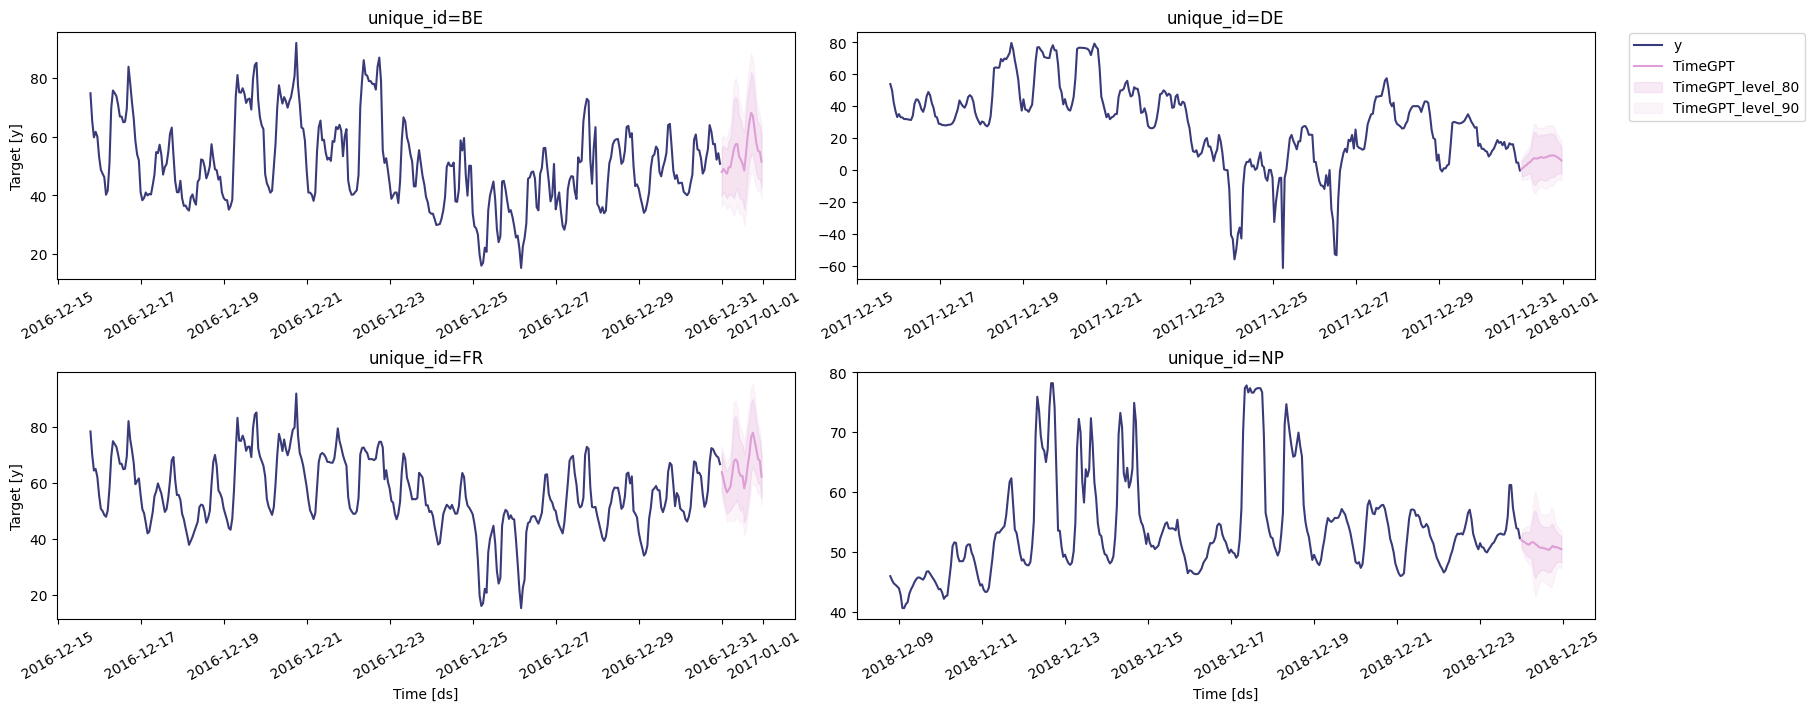

In [ ]:
nixtla_client.plot(
    df[['unique_id', 'ds', 'y']], 
    timegpt_fcst_hist_ex_vars_df, 
    max_insample_length=365, 
    level=[80, 90], 
)

## 3c. Forecasting electricity prices using future and historic exogenous variables

A third option is to use both historic and future exogenous variables. For example, we might not have available the future information for `Exogenous1` and `Exogenous2`. In this example, we drop these variables from our future exogenous dataframe (because we assume we do not know the future value of these variables), and add them to `hist_exog_list` to be considered as historical exogenous variables.

In [ ]:
hist_cols = ["Exogenous1", "Exogenous2"]
future_ex_vars_df_limited = future_ex_vars_df.drop(columns=hist_cols)
timegpt_fcst_ex_vars_df_limited = nixtla_client.forecast(df=df, X_df=future_ex_vars_df_limited, h=24, level=[80, 90], hist_exog_list=hist_cols)

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: h
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using future exogenous features: ['day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6']
INFO:nixtla.nixtla_client:Using historical exogenous features: ['Exogenous1', 'Exogenous2']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


> 📘 Available models in Azure AI
>
> If you are using an Azure AI endpoint, please be sure to set `model="azureai"`:
>
> `nixtla_client.forecast(..., model="azureai")`
> 
> For the public API, we support two models: `timegpt-1` and `timegpt-1-long-horizon`. 
> 
> By default, `timegpt-1` is used. Please see [this tutorial](https://docs.nixtla.io/docs/tutorials-long_horizon_forecasting) on how and when to use `timegpt-1-long-horizon`.

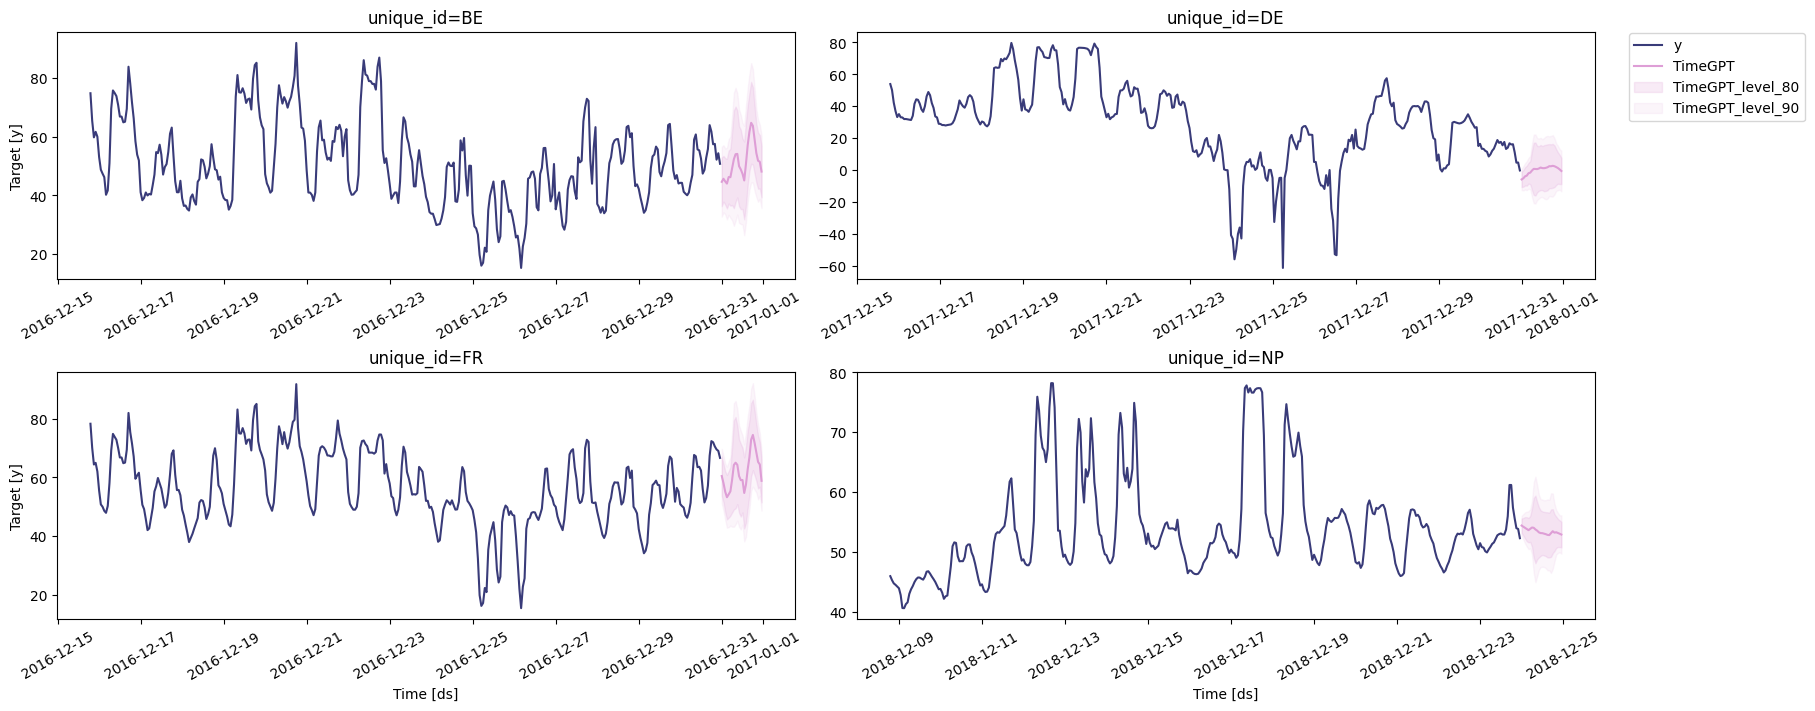

In [ ]:
nixtla_client.plot(
    df[['unique_id', 'ds', 'y']], 
    timegpt_fcst_ex_vars_df_limited, 
    max_insample_length=365, 
    level=[80, 90], 
)

Note that TimeGPT informs you which variables are used as historic exogenous and which are used as future exogenous.

## 3d. Forecasting future exogenous variables

A fourth option in case the future exogenous variables are not available is to forecast them. Below, we'll show you how we can also forecast `Exogenous1` and `Exogenous2` separately, so that you can generate the future exogenous variables in case they are not available.

In [ ]:
# We read the data and create separate dataframes for the historic exogenous that we want to forecast separately.
df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/electricity-short-with-ex-vars.csv')
df_exog1 = df[['unique_id', 'ds', 'Exogenous1']]
df_exog2 = df[['unique_id', 'ds', 'Exogenous2']]

Next, we can use TimeGPT to forecast `Exogenous1` and `Exogenous2`. In this case, we assume these quantities can be separately forecast.

In [ ]:
timegpt_fcst_ex1 = nixtla_client.forecast(df=df_exog1, h=24, target_col='Exogenous1')
timegpt_fcst_ex2 = nixtla_client.forecast(df=df_exog2, h=24, target_col='Exogenous2')

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: h
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: h
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


> 📘 Available models in Azure AI
>
> If you are using an Azure AI endpoint, please be sure to set `model="azureai"`:
>
> `nixtla_client.forecast(..., model="azureai")`
> 
> For the public API, we support two models: `timegpt-1` and `timegpt-1-long-horizon`. 
> 
> By default, `timegpt-1` is used. Please see [this tutorial](https://docs.nixtla.io/docs/tutorials-long_horizon_forecasting) on how and when to use `timegpt-1-long-horizon`.

We can now start creating `X_df`, which contains the future exogenous variables.

In [ ]:
timegpt_fcst_ex1 = timegpt_fcst_ex1.rename(columns={'TimeGPT':'Exogenous1'})
timegpt_fcst_ex2 = timegpt_fcst_ex2.rename(columns={'TimeGPT':'Exogenous2'})

In [ ]:
X_df = timegpt_fcst_ex1.merge(timegpt_fcst_ex2)

Next, we also need to add the `day_0` to `day_6` future exogenous variables. These are easy: this is just the weekday, which we can extract from the `ds` column.

In [ ]:
# We have 7 days, for each day a separate column denoting 1/0
for i in range(7):
    X_df[f'day_{i}'] = 1 * (pd.to_datetime(X_df['ds']).dt.weekday == i)
    

We have now created `X_df`, let's investigate it:

In [ ]:
X_df.head(10)

,unique_id,ds,Exogenous1,Exogenous2,day_0,day_1,day_2,day_3,day_4,day_5,day_6
0,BE,2016-12-31 00:00:00,70861.410,66282.560,0,0,0,0,0,1,0
1,BE,2016-12-31 01:00:00,67851.830,64465.370,0,0,0,0,0,1,0
2,BE,2016-12-31 02:00:00,67246.660,63257.117,0,0,0,0,0,1,0
3,BE,2016-12-31 03:00:00,64027.203,62059.316,0,0,0,0,0,1,0
4,BE,2016-12-31 04:00:00,61524.086,61247.062,0,0,0,0,0,1,0
5,BE,2016-12-31 05:00:00,63054.086,62052.312,0,0,0,0,0,1,0
6,BE,2016-12-31 06:00:00,65199.473,63457.720,0,0,0,0,0,1,0
7,BE,2016-12-31 07:00:00,68285.770,65388.656,0,0,0,0,0,1,0
8,BE,2016-12-31 08:00:00,72038.484,67406.836,0,0,0,0,0,1,0
9,BE,2016-12-31 09:00:00,72821.190,68057.240,0,0,0,0,0,1,0


Let's compare it to our pre-loaded version:

In [ ]:
future_ex_vars_df.head(10)

,unique_id,ds,Exogenous1,Exogenous2,day_0,day_1,day_2,day_3,day_4,day_5,day_6
0,BE,2016-12-31 00:00:00,70318.0,64108.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,BE,2016-12-31 01:00:00,67898.0,62492.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,BE,2016-12-31 02:00:00,68379.0,61571.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,BE,2016-12-31 03:00:00,64972.0,60381.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,BE,2016-12-31 04:00:00,62900.0,60298.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,BE,2016-12-31 05:00:00,62364.0,60339.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,BE,2016-12-31 06:00:00,64242.0,62576.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7,BE,2016-12-31 07:00:00,65884.0,63732.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8,BE,2016-12-31 08:00:00,68217.0,66235.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9,BE,2016-12-31 09:00:00,69921.0,66801.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


As you can see, the values for `Exogenous1` and `Exogenous2` are slightly different, which makes sense because we've made a forecast of these values with TimeGPT.

Let's create a new forecast of our electricity prices with TimeGPT using our new `X_df`:

In [ ]:
timegpt_fcst_ex_vars_df_new = nixtla_client.forecast(df=df, X_df=X_df, h=24, level=[80, 90])
timegpt_fcst_ex_vars_df_new.head()

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: h
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using future exogenous features: ['Exogenous1', 'Exogenous2', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


,unique_id,ds,TimeGPT,TimeGPT-hi-80,TimeGPT-hi-90,TimeGPT-lo-80,TimeGPT-lo-90
0,BE,2016-12-31 00:00:00,37.020070,45.280770,48.887184,28.759370,25.152952
1,BE,2016-12-31 01:00:00,36.721390,44.502422,48.139810,28.940357,25.302969
2,BE,2016-12-31 02:00:00,36.410946,44.295586,47.614098,28.526308,25.207792
3,BE,2016-12-31 03:00:00,32.928810,41.396610,45.105660,24.461010,20.751960
4,BE,2016-12-31 04:00:00,32.202484,41.211320,45.080605,23.193650,19.324368


> 📘 Available models in Azure AI
>
> If you are using an Azure AI endpoint, please be sure to set `model="azureai"`:
>
> `nixtla_client.forecast(..., model="azureai")`
> 
> For the public API, we support two models: `timegpt-1` and `timegpt-1-long-horizon`. 
> 
> By default, `timegpt-1` is used. Please see [this tutorial](https://docs.nixtla.io/docs/tutorials-long_horizon_forecasting) on how and when to use `timegpt-1-long-horizon`.

Let's create a combined dataframe with the two forecasts and plot the values to compare the forecasts.

In [ ]:
timegpt_fcst_ex_vars_df = timegpt_fcst_ex_vars_df.rename(columns={'TimeGPT':'TimeGPT-provided_exogenous'})
timegpt_fcst_ex_vars_df_new = timegpt_fcst_ex_vars_df_new.rename(columns={'TimeGPT':'TimeGPT-forecasted_exogenous'})

forecasts = timegpt_fcst_ex_vars_df[['unique_id', 'ds', 'TimeGPT-provided_exogenous']].merge(timegpt_fcst_ex_vars_df_new[['unique_id', 'ds', 'TimeGPT-forecasted_exogenous']])

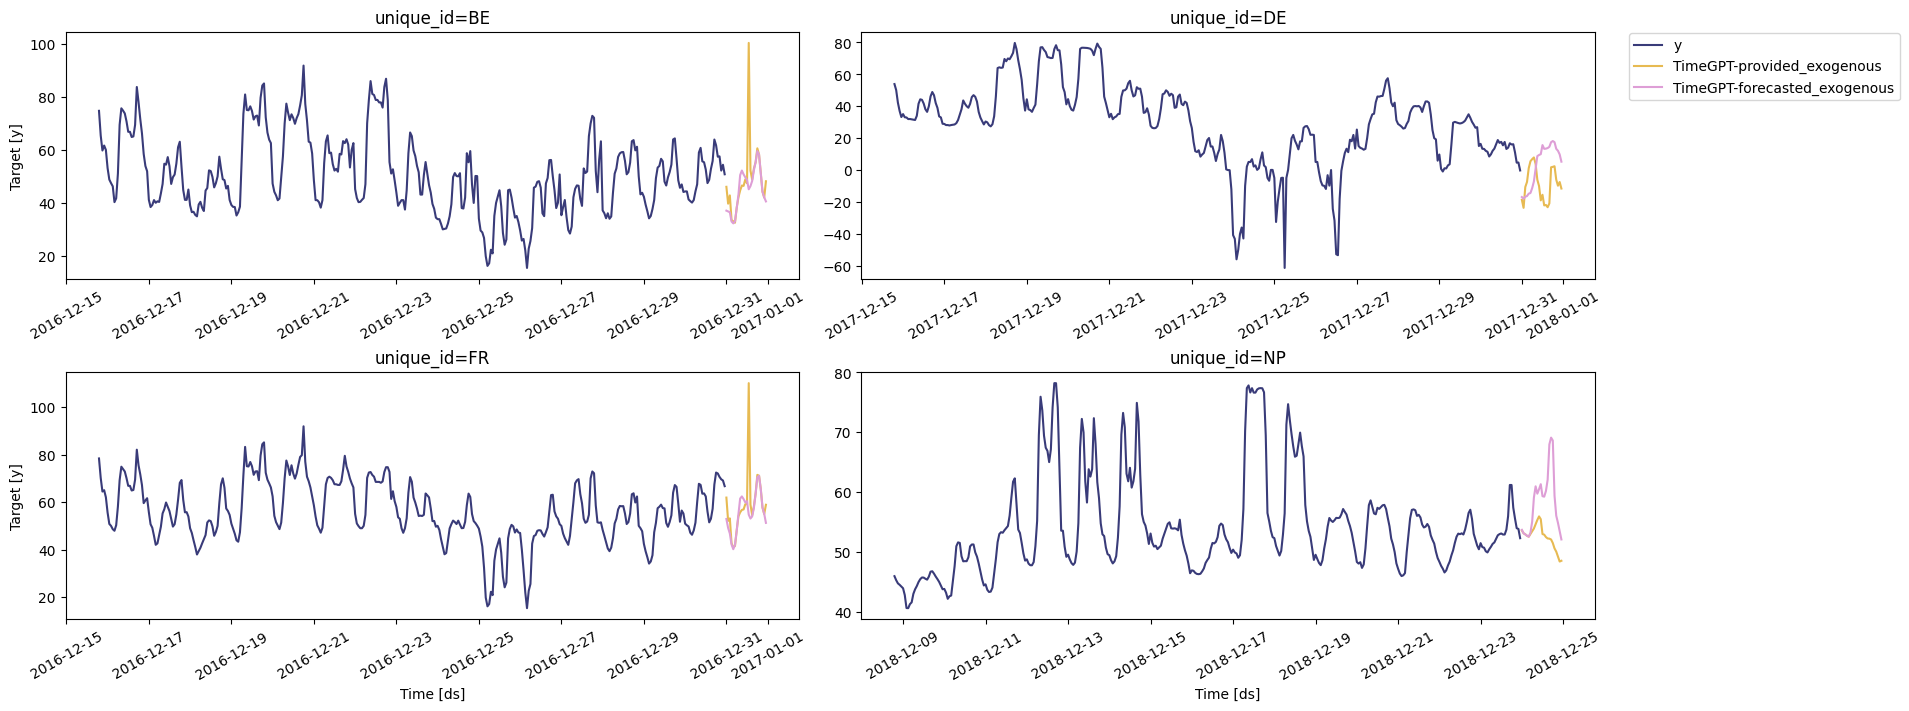

In [ ]:
nixtla_client.plot(
    df[['unique_id', 'ds', 'y']], 
    forecasts, 
    max_insample_length=365, 
)

As you can see, we obtain a slightly different forecast if we use our forecasted exogenous variables. 